In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import pickle
import gillespy2 as gp

In [2]:
model_name = 'SIR'
timestep = 0.5
endtime = 20
dataset_id = 1
model_id = 1
nb_features = 3
nb_settings = 5
params_to_randomize = ['beta', 'gamma']
# params_to_randomize = None

In [31]:
files = list(Path('trajectories').glob('*'))
len(files)

4

In [32]:
# raw gillespy trajectories
t_list = []
for fname in files:
    with open(fname, 'rb') as f:
        t_list.append(pickle.load(f))

In [43]:
len(t_list)

4

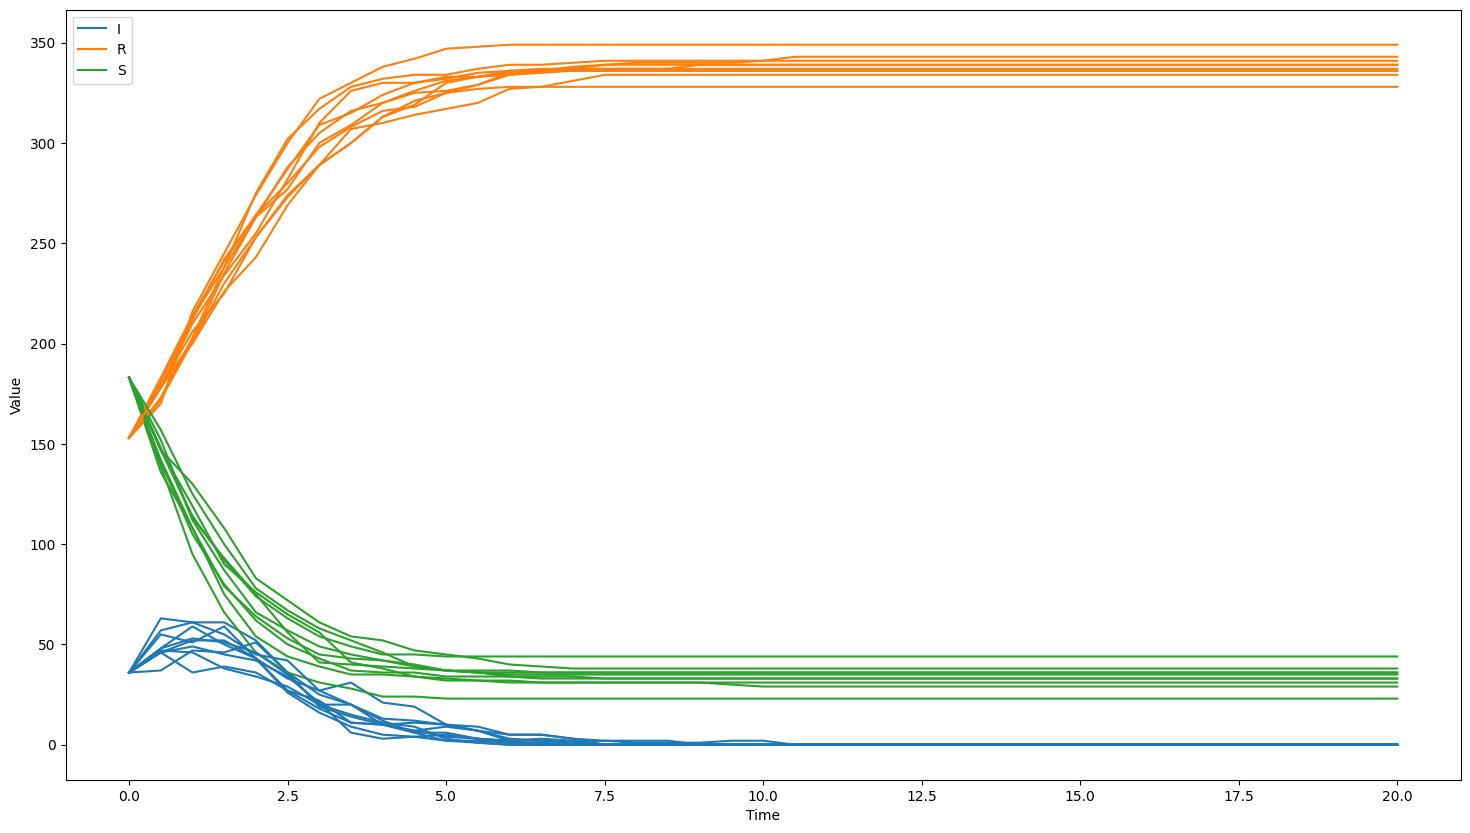

In [5]:
t_list[0].plot()

In [50]:
t = t_list[0].to_array()
t = np.vstack(t)
t.shape

(410, 4)

In [6]:
t_list_transformed = [t.to_array() for t in t_list]

In [7]:
from importlib import import_module

crn_module = import_module("SIR")
crn_class = getattr(crn_module, model_name)
crn_instance = crn_class(endtime, timestep)

param_settings = []
if params_to_randomize is not None:
    randomized = crn_instance.get_randomized_parameters(params_to_randomize, nb_settings)
    for i in range(nb_settings):
        d = {}
        for key in randomized:
            d[key] = randomized[key][i]
        param_settings.append(d)

In [8]:
settings = np.load(r'dataset\data\0.5\1\settings.npy')

if param_settings:
    kwargs = [(settings[n], n, param_settings[n]) for n in range(nb_settings)]
else:
    kwargs = [(settings[n], n, None) for n in range(nb_settings)]

In [42]:
kwargs

[(array([113,  70,  61]),
  0,
  {'beta': 1.8923113407708265, 'gamma': 1.0620424909517743}),
 (array([121,  69, 120]),
  1,
  {'beta': 3.0170772025371395, 'gamma': 0.692567172583948}),
 (array([183,  36, 153]),
  2,
  {'beta': 3.5267174037520808, 'gamma': 0.7311767085171219}),
 (array([42, 79, 42]),
  3,
  {'beta': 2.686344090690419, 'gamma': 1.3126135561057977}),
 (array([51, 78, 71]),
  4,
  {'beta': 2.8858734278048637, 'gamma': 0.9981689162701964})]

In [9]:
params_dicts = [x[2] for x in kwargs]
params_dicts

[{'beta': 1.8923113407708265, 'gamma': 1.0620424909517743},
 {'beta': 3.0170772025371395, 'gamma': 0.692567172583948},
 {'beta': 3.5267174037520808, 'gamma': 0.7311767085171219},
 {'beta': 2.686344090690419, 'gamma': 1.3126135561057977},
 {'beta': 2.8858734278048637, 'gamma': 0.9981689162701964}]

In [10]:
if params_dicts is not None:
    for i, l in enumerate(t_list_transformed):
        for j, t in enumerate(l):
            vals = np.array(list(params_dicts[i].values()))
            x = np.ones(list(t.shape[:-1]) + [1]) * vals
            l[j] = np.concatenate([t, x], axis=-1)

In [11]:
stacked = np.vstack(t_list_transformed)
stacked.shape

(40, 41, 6)

In [12]:
np.save(r'mimosa\stacked.npy', stacked)

In [13]:
from stochnet_v2.dataset.dataset import DataTransformer, HDF5Dataset

dt = DataTransformer(
    r'mimosa\stacked.npy',
    with_timestamps=True
)

In [14]:
dt.data.shape

(40, 41, 6)

In [15]:
np.random.seed(11)

dt.save_data_for_ml_hdf5(
    dataset_folder='mimosis',
    nb_past_timesteps=1,
    test_fraction=0.2,
    keep_timestamps=False,
    rescale=True,
    positivity=False,
    shuffle=True,
    slice_size=100,
    force_rewrite=True
)

dataset.dataset - INFO - Fitting scaler, positivity=False


0it [00:00, ?it/s]


TypeError: Can't broadcast (1280, 0) -> (1280, 5)

In [16]:
import h5py

data_file = h5py.File(r'mimosis\train_rescaled.hdf5', 'r')

x_data = data_file['x']
y_data = data_file['y']

i = 200

dt.scale_back(x_data[i]), dt.scale_back(y_data[i])

(array([[ 11.99999993, 218.99999997,  13.00000002,   3.01707721,
           0.69256717]]),
 array([  9.89146341, 216.80304878,  18.0554878 ,   2.78061253,
          0.9496    ]))

In [17]:
ds = HDF5Dataset(r'mimosis\train_rescaled.hdf5', 64)

In [18]:
c = 0

for x, y in ds:
    print(f'{x.shape}, {y.shape}')
    c += 1
    if c > 10:
        break
    else:
        continue
    break

(64, 1, 5), (64, 5)
(64, 1, 5), (64, 5)
(64, 1, 5), (64, 5)
(64, 1, 5), (64, 5)
(64, 1, 5), (64, 5)
(64, 1, 5), (64, 5)
(64, 1, 5), (64, 5)
(64, 1, 5), (64, 5)
(64, 1, 5), (64, 5)
(64, 1, 5), (64, 5)
(64, 1, 5), (64, 5)


In [19]:
# configure model

body_n_cells = 2
body_cell_size = 2
body_expansion_multiplier = 20
body_n_states_reduce = 2
body_kernel_constraint = "none"
body_bias_constraint = "none"
body_kernel_regularizer = "l2"
body_bias_regularizer = "l2"
body_regularizer = "none"

components_hidden_size = "none"
n_normal_diag = 6
n_normal_tril = 0
n_log_normal_tril = 0
components_activation = "none"
components_regularizer = "none"
components_kernel_constraint = "none"
components_bias_constraint = "none"
components_kernel_regularizer = "l2"
components_bias_regularizer = "l2"


body_config = {
    "n_cells": body_n_cells,
    "cell_size": body_cell_size,
    "expansion_multiplier": body_expansion_multiplier,
    "n_states_reduce": body_n_states_reduce,
    "kernel_constraint": body_kernel_constraint,
    "kernel_regularizer": body_kernel_regularizer,
    "bias_constraint": body_bias_constraint,
    "bias_regularizer": body_bias_regularizer,
    "activity_regularizer": body_regularizer,
}

categorical_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "coeff_regularizer": "none",
    "kernel_constraint": body_kernel_constraint,  # unitnorm
    "bias_constraint": body_bias_constraint,  # unitnorm
    "kernel_regularizer": components_kernel_regularizer,
    "bias_regularizer": components_bias_regularizer
}

normal_diag_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "mu_regularizer": components_regularizer,
    "diag_regularizer": "l2",
    "kernel_constraint": components_kernel_constraint,
    "bias_constraint": components_bias_constraint,
    "kernel_regularizer": components_kernel_regularizer,
    "bias_regularizer": components_bias_regularizer
}

normal_tril_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "mu_regularizer": components_regularizer,
    "diag_regularizer": components_regularizer,
    "sub_diag_regularizer": components_regularizer,
    "kernel_constraint": components_kernel_constraint,
    "bias_constraint": components_bias_constraint,
    "kernel_regularizer": components_kernel_regularizer,
    "bias_regularizer": components_bias_regularizer
}

log_normal_tril_config = {
    "hidden_size": components_hidden_size,
    "activation": components_activation,
    "mu_regularizer": components_regularizer,
    "diag_regularizer": components_regularizer,
    "sub_diag_regularizer": components_regularizer,
    "kernel_constraint": components_kernel_constraint,
    "bias_constraint": components_bias_constraint,
    "kernel_regularizer": components_kernel_regularizer,
    "bias_regularizer": components_bias_regularizer
}

In [21]:
import json

mixture_config = \
[["categorical", categorical_config]] + \
[["normal_diag", normal_diag_config] for i in range(n_normal_diag)] + \
[["normal_tril", normal_tril_config] for i in range(n_normal_tril)] + \
[["log_normal_tril", log_normal_tril_config] for i in range(n_log_normal_tril)]

with open(r'configs\body_config.json', 'w+') as f:
    json.dump(body_config, f, indent='\t')

with open(r'configs\mixture_config.json', 'w+') as f:
    json.dump(mixture_config, f, indent='\t')

In [22]:
# configure training strategy
from stochnet_v2.static_classes.trainer import ToleranceDropLearningStrategy

learning_strategy_main = ToleranceDropLearningStrategy(
    optimizer_type='adam',
    initial_lr=1e-4,
    lr_decay=0.3,
    epochs_tolerance=7,
    minimal_lr=1e-7,
)

learning_strategy_arch = ToleranceDropLearningStrategy(
    optimizer_type='adam',
    initial_lr=1e-3,
    lr_decay=0.5,
    epochs_tolerance=20,
    minimal_lr=1e-7,
)

learning_strategy_finetune = ToleranceDropLearningStrategy(
    optimizer_type='adam',
    initial_lr=1e-4,
    lr_decay=0.3,
    epochs_tolerance=5,
    minimal_lr=1e-7,
)

n_epochs_main = 100
n_epochs_heat_up = 20
n_epochs_interval = 5
n_epochs_arch = 5
n_epochs_finetune = 40
batch_size = 256
dataset_kind = 'hdf5'
add_noise = True
stddev = 0.01

In [27]:
# initialise model

from stochnet_v2.dynamic_classes.model import NASStochNet

nn = NASStochNet(
    nb_past_timesteps=1,
    nb_features=nb_features,
    nb_randomized_params=len(params_to_randomize),
    project_folder=Path(''),
    timestep=timestep,
    dataset_id=dataset_id,
    model_id=model_id,
)

static_classes.top_layers - DEBUG - Mixture components share nn outputs
static_classes.top_layers - DEBUG - base shape: [None, 100]
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.top_layers - DEBUG - Using non-nnegative elu activation for diagonal
static_classes.model - INFO - Model's graph keys saved at .\models\0.5\1\graph_keys.json
static_classes.model - INFO - Model created in normal mode.


In [30]:
from stochnet_v2.dynamic_classes.trainer import Trainer

ckpt_path = None

ckpt_path = Trainer().train(
    nn,
    n_epochs_main=n_epochs_main,
    n_epochs_heat_up=n_epochs_heat_up,
    n_epochs_arch=n_epochs_arch,
    n_epochs_interval=n_epochs_interval,
    n_epochs_finetune=n_epochs_finetune,
    batch_size=batch_size,
    learning_strategy_main=learning_strategy_main,
    learning_strategy_arch=learning_strategy_arch,
    learning_strategy_finetune=learning_strategy_finetune,
    ckpt_path=ckpt_path,
    dataset_kind=dataset_kind,
    add_noise=add_noise,
    stddev=stddev,
    mode=['search', 'finetune']
)

ckpt_path

dynamic_classes.trainer - INFO - 
Training MAIN...

dynamic_classes.trainer - DEBUG - Total number of trainable vars 138
dynamic_classes.trainer - DEBUG - Total number of main optimizer vars 278
dynamic_classes.trainer - INFO - 
Epoch: 1


ValueError: Cannot feed value of shape (256, 5) for Tensor 'random_variable_output:0', which has shape '(?, 3)'

In [11]:
# convert to numpy arrays

# using np.array()
np1 = np.array(t)

# usining t.to_array()
np2 = t.to_array()

In [14]:
# see types
print(f't: {type(t)}')
print(f'np1: {type(np1)}')
print(f'np2: {type(np2)}')

t: <class 'gillespy2.core.results.Results'>
np1: <class 'numpy.ndarray'>
np2: <class 'list'>


In [32]:
# see structure when properly converting trajectories to np.array
print(f'parent type: {type(np2)}')
print(f'number of children: {len(np2)}')
print()
print(f'child type: {type(np2[0])}')
print(f'child dimensions (endtime/timestep x number of species + 1 (time)): {np2[0].shape}')
print(f'child:\n{np2[0]}')

parent type: <class 'list'>
number of children: 50

child type: <class 'numpy.ndarray'>
child dimensions (endtime/timestep x number of species + 1 (time)): (41, 4)
child:
[[  0.  189.  136.  115. ]
 [  0.5 144.  221.   75. ]
 [  1.   98.  287.   55. ]
 [  1.5  53.  340.   47. ]
 [  2.   32.  367.   41. ]
 [  2.5  12.  388.   40. ]
 [  3.   10.  390.   40. ]
 [  3.5   9.  393.   38. ]
 [  4.    6.  396.   38. ]
 [  4.5   2.  401.   37. ]
 [  5.    2.  401.   37. ]
 [  5.5   0.  403.   37. ]
 [  6.    0.  403.   37. ]
 [  6.5   0.  403.   37. ]
 [  7.    0.  403.   37. ]
 [  7.5   0.  403.   37. ]
 [  8.    0.  403.   37. ]
 [  8.5   0.  403.   37. ]
 [  9.    0.  403.   37. ]
 [  9.5   0.  403.   37. ]
 [ 10.    0.  403.   37. ]
 [ 10.5   0.  403.   37. ]
 [ 11.    0.  403.   37. ]
 [ 11.5   0.  403.   37. ]
 [ 12.    0.  403.   37. ]
 [ 12.5   0.  403.   37. ]
 [ 13.    0.  403.   37. ]
 [ 13.5   0.  403.   37. ]
 [ 14.    0.  403.   37. ]
 [ 14.5   0.  403.   37. ]
 [ 15.    0.  403. 

In [41]:
np2

[array([[  0. , 189. , 136. , 115. ],
        [  0.5, 144. , 221. ,  75. ],
        [  1. ,  98. , 287. ,  55. ],
        [  1.5,  53. , 340. ,  47. ],
        [  2. ,  32. , 367. ,  41. ],
        [  2.5,  12. , 388. ,  40. ],
        [  3. ,  10. , 390. ,  40. ],
        [  3.5,   9. , 393. ,  38. ],
        [  4. ,   6. , 396. ,  38. ],
        [  4.5,   2. , 401. ,  37. ],
        [  5. ,   2. , 401. ,  37. ],
        [  5.5,   0. , 403. ,  37. ],
        [  6. ,   0. , 403. ,  37. ],
        [  6.5,   0. , 403. ,  37. ],
        [  7. ,   0. , 403. ,  37. ],
        [  7.5,   0. , 403. ,  37. ],
        [  8. ,   0. , 403. ,  37. ],
        [  8.5,   0. , 403. ,  37. ],
        [  9. ,   0. , 403. ,  37. ],
        [  9.5,   0. , 403. ,  37. ],
        [ 10. ,   0. , 403. ,  37. ],
        [ 10.5,   0. , 403. ,  37. ],
        [ 11. ,   0. , 403. ,  37. ],
        [ 11.5,   0. , 403. ,  37. ],
        [ 12. ,   0. , 403. ,  37. ],
        [ 12.5,   0. , 403. ,  37. ],
        [ 13

In [3]:
d1_raw = np.load(r'raw_gilles\1-raw.npy')
d1_concat = np.load(r'raw_gilles\1-concat.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'raw_gilles\\1-raw.npy'

In [25]:
d1_raw.shape

(50, 4)

In [26]:
d1_concat.shape

(50, 6)

In [27]:
d1_raw[:5]

array([['time', 'I', 'R', 'S'],
       ['time', 'I', 'R', 'S'],
       ['time', 'I', 'R', 'S'],
       ['time', 'I', 'R', 'S'],
       ['time', 'I', 'R', 'S']], dtype='<U4')

In [28]:
d1_concat[:5]

array([['time', 'I', 'R', 'S', '3.5187543378893533', '1.27930157985705'],
       ['time', 'I', 'R', 'S', '3.5187543378893533', '1.27930157985705'],
       ['time', 'I', 'R', 'S', '3.5187543378893533', '1.27930157985705'],
       ['time', 'I', 'R', 'S', '3.5187543378893533', '1.27930157985705'],
       ['time', 'I', 'R', 'S', '3.5187543378893533', '1.27930157985705']],
      dtype='<U32')

In [20]:
print(f'50x33: {50*33}\n41x33: {41*33}\n4x33: {4*33}')

50x33: 1650
41x33: 1353
4x33: 132


In [21]:
d = np.load(r'dataset\data\0.5\1\dataset.npy')

In [22]:
d.shape

(5000, 6)

In [23]:
d[:10]

array([['time', 'I', 'R', 'S', '2.509733153667801', '1.206265486819297'],
       ['time', 'I', 'R', 'S', '2.509733153667801', '1.206265486819297'],
       ['time', 'I', 'R', 'S', '2.509733153667801', '1.206265486819297'],
       ['time', 'I', 'R', 'S', '2.509733153667801', '1.206265486819297'],
       ['time', 'I', 'R', 'S', '2.509733153667801', '1.206265486819297'],
       ['time', 'I', 'R', 'S', '2.509733153667801', '1.206265486819297'],
       ['time', 'I', 'R', 'S', '2.509733153667801', '1.206265486819297'],
       ['time', 'I', 'R', 'S', '2.509733153667801', '1.206265486819297'],
       ['time', 'I', 'R', 'S', '2.509733153667801', '1.206265486819297'],
       ['time', 'I', 'R', 'S', '2.509733153667801', '1.206265486819297']],
      dtype='<U32')

## Comparison
Gillespy2 trajectories vs. np.array(trajectories) vs. trajectories.to_array()

In [33]:
import pickle
from gillespy2.core.results import Results

In [30]:
# raw gillesphy trajectories
with open(r'trajectories\1.pkl', 'rb') as f:
    traj = pickle.load(f)
    
# trajectories converted with np.array()
traj_np = np.load(r'np_arrays\1.npy')

# trajectories converted with .to_array()
traj_ar = np.load(r'to_arrays\1.npy')

2021-12-09 15:09:34,059 - root - WARNING - Unable to use C++ optimized solvers due to one or more missing dependencies: ['make']. The performance of this package can be significantly increased if you install/configure these on your machine.


In [56]:
print(f'{len(traj_d["data"])}\n{traj_np.shape}\n{traj_ar.shape}')

50
(50, 4)
(50, 41, 4)


In [64]:
traj_ar[0, :, :]

array([[  0. , 189. , 136. , 115. ],
       [  0.5, 144. , 221. ,  75. ],
       [  1. ,  98. , 287. ,  55. ],
       [  1.5,  53. , 340. ,  47. ],
       [  2. ,  32. , 367. ,  41. ],
       [  2.5,  12. , 388. ,  40. ],
       [  3. ,  10. , 390. ,  40. ],
       [  3.5,   9. , 393. ,  38. ],
       [  4. ,   6. , 396. ,  38. ],
       [  4.5,   2. , 401. ,  37. ],
       [  5. ,   2. , 401. ,  37. ],
       [  5.5,   0. , 403. ,  37. ],
       [  6. ,   0. , 403. ,  37. ],
       [  6.5,   0. , 403. ,  37. ],
       [  7. ,   0. , 403. ,  37. ],
       [  7.5,   0. , 403. ,  37. ],
       [  8. ,   0. , 403. ,  37. ],
       [  8.5,   0. , 403. ,  37. ],
       [  9. ,   0. , 403. ,  37. ],
       [  9.5,   0. , 403. ,  37. ],
       [ 10. ,   0. , 403. ,  37. ],
       [ 10.5,   0. , 403. ,  37. ],
       [ 11. ,   0. , 403. ,  37. ],
       [ 11.5,   0. , 403. ,  37. ],
       [ 12. ,   0. , 403. ,  37. ],
       [ 12.5,   0. , 403. ,  37. ],
       [ 13. ,   0. , 403. ,  37. ],
 

In [86]:
df = pd.DataFrame(traj[0].to_dict()['data'])
df.head()

,time,I,R,S
0,0.0,189.0,136.0,115.0
1,0.5,144.0,221.0,75.0
2,1.0,98.0,287.0,55.0
3,1.5,53.0,340.0,47.0
4,2.0,32.0,367.0,41.0


In [82]:
type(traj[0])

gillespy2.core.results.Trajectory

In [59]:
len(traj_d['data'][0]['I'])

41

In [52]:
traj_d = traj.to_dict()

In [40]:
print(f'np:\n{traj_np[0, :]}\n\ngp:\n{traj_ar[0, :, :]}')

np:
['time' 'I' 'R' 'S']

gp:
[[  0.  189.  136.  115. ]
 [  0.5 144.  221.   75. ]
 [  1.   98.  287.   55. ]
 [  1.5  53.  340.   47. ]
 [  2.   32.  367.   41. ]
 [  2.5  12.  388.   40. ]
 [  3.   10.  390.   40. ]
 [  3.5   9.  393.   38. ]
 [  4.    6.  396.   38. ]
 [  4.5   2.  401.   37. ]
 [  5.    2.  401.   37. ]
 [  5.5   0.  403.   37. ]
 [  6.    0.  403.   37. ]
 [  6.5   0.  403.   37. ]
 [  7.    0.  403.   37. ]
 [  7.5   0.  403.   37. ]
 [  8.    0.  403.   37. ]
 [  8.5   0.  403.   37. ]
 [  9.    0.  403.   37. ]
 [  9.5   0.  403.   37. ]
 [ 10.    0.  403.   37. ]
 [ 10.5   0.  403.   37. ]
 [ 11.    0.  403.   37. ]
 [ 11.5   0.  403.   37. ]
 [ 12.    0.  403.   37. ]
 [ 12.5   0.  403.   37. ]
 [ 13.    0.  403.   37. ]
 [ 13.5   0.  403.   37. ]
 [ 14.    0.  403.   37. ]
 [ 14.5   0.  403.   37. ]
 [ 15.    0.  403.   37. ]
 [ 15.5   0.  403.   37. ]
 [ 16.    0.  403.   37. ]
 [ 16.5   0.  403.   37. ]
 [ 17.    0.  403.   37. ]
 [ 17.5   0.  403.   37. 